**Lab 7 : Node2Vec**
- Instuctor : Kijung Shin
- Teaching Assistants : Hyunju Lee(main), Deukryeol Yoon, Shinhwan Kang 
- 본 실습에서는 random walk 기반 network embedding 방법 중 하나인 node2vec 알고리즘을 사용하여 clustering, node classification과 같은 여러 downstream task들을 수행해본다.

* 학습 목표

> 1. node2vec library의 사용법을 익힌다.
2. node2vec embedding 벡터를 사용하여 여러 downstream tasks(clustering, node classification)를 수행하는 방법을 익힌다.




## Clustering with Node2Vec

In [29]:
import os
import sys

import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt

In [ ]:
###################### Dataset Description ##########################
'''
    [Reference]
        title={The Network Data Repository with Interactive Graph Analytics and Visualization},
        author={Ryan A. Rossi and Nesreen K. Ahmed},
        booktitle={AAAI},
        url={http://networkrepository.com},
        year={2015}

'''
###### lesmis.mtx : <node 1> <node 2> <weight> ######################
###### weight : 레미제라블에 동시에 등장한 등장인물의 횟수 ##########
#####################################################################

In [44]:
##### Weighted Graph Generation #####

FILE_PATH = os.path.join('graph', 'lab', 'lab7', 'lesmis.mtx')
weighted_edgelist = []

with open(FILE_PATH, 'r') as f:
    for line in f:
        l = line.strip().split()
        if l[0].isdigit() == False:
            continue
        value = [str(int(l[0]) - 1), str(int(l[1]) - 1), float(l[2])]
        weighted_edgelist.append(value)

In [45]:
weighted_edgelist[:5]

[['76', '76', 254.0],
 ['1', '0', 1.0],
 ['2', '0', 8.0],
 ['3', '0', 10.0],
 ['4', '0', 1.0]]

In [46]:
G = nx.Graph()
G.add_weighted_edges_from(weighted_edgelist)

In [47]:
# edge 별 확률 계산(p, q에 따른 edge별 확률 계산) & random walk 생성 
node2vec = Node2Vec(G,
                    dimensions = 16,
                    walk_length = 4,
                    num_walks = 200,
                    workers = 4)  # p = 1, q = 1 as default

# node embedding 구하기
model = node2vec.fit(window = 2,
                     min_count = 1,
                     batch_words = 4)

In [48]:
print("#### Embedding Vector of Node 2 ####")
print(model.wv['2'])

#### Embedding Vector of Node 2 ####
[-0.5965929  -0.976168    0.55454904  0.20596774  0.03093667  0.6691666
 -0.7244549  -0.7383088   0.2424277  -1.0698895  -0.98930985 -0.06130071
 -0.02612203 -0.7067945   1.3439697   0.47778705]


In [49]:
##### Node 2와 가장 유사한 10개의 node를 출력 #####

print("#### Most Similar Nodes to Node 2")
model.wv.most_similar('2')  

#### Most Similar Nodes to Node 2


[('3', 0.9937043190002441),
 ('5', 0.9925392866134644),
 ('6', 0.9923713207244873),
 ('1', 0.9916898012161255),
 ('9', 0.9908527135848999),
 ('8', 0.9885632991790771),
 ('4', 0.9871704578399658),
 ('7', 0.9868944883346558),
 ('0', 0.9852105379104614),
 ('14', 0.6317763924598694)]

In [51]:
import numpy as np

from sklearn.cluster import KMeans

In [52]:
#### sklearn.cluster의 KMeans 알고리즘을 실행시키기 위해 node별 embedding 값을 array로 변환해준다 
#### 노드 번호에 해당하는 index에 embedding 값을 저장
vectors_array = np.zeros((len(G.nodes), 16))

for node in G.nodes:
    vectors_array[int(node)] = model.wv[node]

In [53]:
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(vectors_array)

In [57]:
G.nodes

NodeView(('76', '1', '0', '2', '3', '4', '5', '6', '7', '8', '9', '11', '10', '12', '13', '14', '15', '23', '24', '25', '26', '27', '28', '29', '31', '32', '33', '34', '35', '36', '37', '38', '43', '44', '48', '49', '51', '55', '58', '64', '68', '69', '70', '71', '72', '17', '16', '18', '19', '20', '21', '22', '30', '41', '42', '50', '39', '40', '75', '54', '45', '52', '57', '62', '47', '46', '59', '60', '61', '63', '65', '66', '73', '74', '56', '53', '67'))

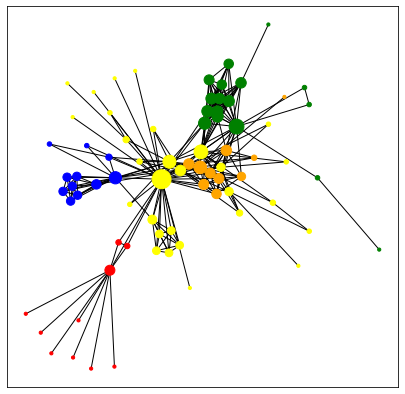

In [55]:
#### 그래프 시각화 - 각 클러스터별로 다른 색깔을 갖도록 함 ####
pos = nx.spring_layout(G)
node_color=[]
node_degree = []
for node in G.nodes:
    node_degree.append(G.degree[node] * 10)
    i = int(node)
    if kmeans.labels_[i] == 0:
        node_color.append('red')
        
    elif kmeans.labels_[i] == 1:
        node_color.append('yellow')
        
    elif kmeans.labels_[i] == 2:
        node_color.append('blue')
        
    elif kmeans.labels_[i] == 3:
        node_color.append('green')
        
    else:
        node_color.append('orange')

plt.figure(figsize = (7,7))
img = nx.draw_networkx_nodes(G, pos, node_color = node_color, node_size=node_degree)
nx.draw_networkx_edges(G, pos)
plt.show()

## Node Calssification

In [56]:
###################### Dataset Description ##########################
##### cora.content : <paper_id> <word_attributes> <class_name> #####
##### cora.cites : <ID of cited paper> <ID of citing paper> #########
#####################################################################

In [68]:
# Directed Graph Generation 
# 메모리 활용을 위해 node class는 숫자로 re-labelling하여 사용

node_class = dict()
edgelist = list()
class_num = 1
class_name_to_num = dict()
FILE1_PATH = os.path.join('graph', 'lab', 'lab7', 'cora.content')
FILE2_PATH = os.path.join('graph', 'lab', 'lab7', 'cora.cites')

with open(FILE1_PATH, 'r') as f, open(FILE2_PATH, 'r') as f2:
    for line in f:
        l = line.strip().split()
        class_name = l[-1]
        if class_name not in class_name_to_num:
            class_name_to_num[class_name] = class_num
            class_num += 1
        node_class[l[0]] = class_name_to_num[class_name]

    for line in f2:
        l = line.strip().split()
        edgelist.append((l[1],l[0]))

In [69]:
G = nx.DiGraph()
G.add_edges_from(edgelist)

In [70]:
import time

In [71]:
s= time.time()
##### Node Embedding #####
node2vec = Node2Vec(G,
                    dimensions = 16,
                    walk_length = 4,
                    num_walks = 200,
                    workers = 4)

model = node2vec.fit(window = 10,
                     min_count = 1,
                     batch_words = 4)

print("runtime: ", time.time() - s)


runtime:  138.33479380607605


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score

In [73]:
#### X : embedding of a node, y : class label of a node ####

X = list()
y = list()
node_name_to_idx = dict()

for i, (v, class_) in enumerate(node_class.items()):
    node_name_to_idx[v] = i
    X.append(model.wv[v])
    y.append(class_)
    
X = np.array(X)
y = np.array(y)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True)

clf = MLPClassifier(max_iter = 500).fit(X_train, y_train)

/Users/jinseok/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [75]:
y_predict = clf.predict(X_test)

print("###### Result of prediction #####")
print("Accuracy : {0:05.2f}% ".format(accuracy_score(y_test, y_predict)*100))

###### Result of prediction #####
Accuracy : 79.03% 


In [79]:
print("########## Comparison of Predicted and Test Results ######")
for i in range(len(y_test)//20):
    print('-' * 50)
    print("예측: ", y_predict[i*20:(i+1)*20])
    print("실제: ", y_test[i*20:(i+1)*20])

########## Comparison of Predicted and Test Results ######
--------------------------------------------------
예측:  [4 4 4 1 4 4 4 4 1 6 5 4 6 1 3 1 3 4 5 7]
실제:  [5 4 4 1 4 4 4 4 1 6 5 7 6 1 3 3 3 1 5 7]
--------------------------------------------------
예측:  [2 4 1 1 4 1 3 1 5 2 1 3 1 3 7 4 1 1 6 4]
실제:  [2 4 3 1 4 1 1 1 5 7 6 3 1 1 7 4 3 4 6 4]
--------------------------------------------------
예측:  [4 4 1 7 2 5 5 7 5 2 1 5 7 1 1 6 7 5 6 1]
실제:  [4 6 5 7 5 5 5 2 6 2 1 5 7 5 1 6 2 7 6 1]
--------------------------------------------------
예측:  [6 1 2 3 1 6 5 1 1 7 6 6 2 5 1 4 6 1 1 1]
실제:  [6 1 2 3 1 6 1 6 1 7 6 1 2 5 1 4 3 1 1 2]
--------------------------------------------------
예측:  [2 1 7 6 5 1 4 1 4 1 1 4 1 3 1 4 7 5 1 1]
실제:  [2 5 7 6 7 1 4 6 4 1 1 4 1 3 3 1 2 1 5 1]
--------------------------------------------------
예측:  [5 1 1 6 4 5 4 1 2 1 1 5 3 7 1 6 7 2 6 6]
실제:  [5 1 5 6 4 5 1 1 2 1 1 3 3 1 5 6 6 2 6 6]
--------------------------------------------------
예측:  [6 2 5 3 7 4 5 